In [207]:
import matplotlib.pyplot as plt
from itertools import accumulate
from scipy.stats import norm
from statistics import mean,variance
from math import sqrt,log,inf,exp
import csv
import time
from sortedcontainers import SortedList as OST
from functools import reduce

## Background

This notebook introduces a Python API that provides algorithms for undertaking changepoint detection in ordered univariate data sets. These core algorithms take as inputs cost functions, which in practice typically, (but not necessarily), take the form

$f : \cal{N} \times \cal{N} \rightarrow \cal{R}$ 

subject to the constraint $f(a,b) + f(b,c) <= f(a,c)$ where $a \leq b \leq c$.

The API has adopted this approach so that the new cost functions can easily implemented for use with the core methods. 

More generally the form of the cost function is

$f : X \times X \rightarrow Y$ where $X$ and $Y$ are sets with a sense of (total) ordering (e.g. there exists a "< like" relation for the sets).  

### An example cost function

A cost function does not necessarily have to be a python function. It only has to be a "callable" ("invokable") object (which of course includes standard Python functions). A versatile template for a such a callable object which satisfies the general requirements of the cost functions outlined previously is shown below.

In [160]:
class cost_function :
    def __init__(self,data) : # extra parameters can be passed here if necessary
        pass # only present to make this template code valid Python
        # setup function state here
    def __call__(self,a,b) :
        # calculate c 
        return c

Here is a concrete example of a cost function which can be used in conjunction with the core algorithms to detect changes in mean in a data set that has an underlying uniform normal distribution. 

In [173]:
class normal_mean :
    def __init__(self,X) :
        self.X = X
        self.SX = [0] + list(accumulate(X))
        self.SXX = [0] + list(accumulate([x*x for x in X]))
    def __call__(self,i,j) :
        val = self.SX[j+1] - self.SX[i]
        val *= val
        val /= (j - i + 1)
        val = -val
        val += self.SXX[j+1] - self.SXX[i]
        return val

This stateful function (functor) can be used as follows.

#### generate some test data

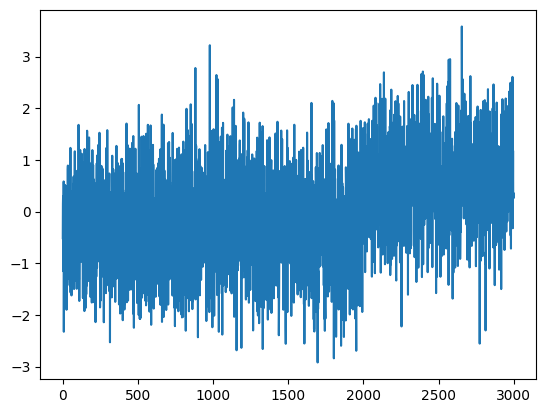

In [183]:
X = [0.0 for i in range(2000)] + [1.0 for i in range(1000)]
E = norm.rvs(size=len(X))
Z = [x+e for x,e in zip(X,E)]
mu = mean(Z)
sigma = sqrt(variance(Z))
Z = [(z-mu)/sigma for z in Z] # normalise the data
plt.plot(Z)
plt.show()

#### instantiate the functor

In [184]:
f = normal_mean(Z)

#### call the functor

In [185]:
f(10,27)

9.03890449900895

#### demonstrate a basic characteristic of the cost function

In [186]:
f(0,9) + f(10,19) <= f(0,20)


True

#### visualise the cost function

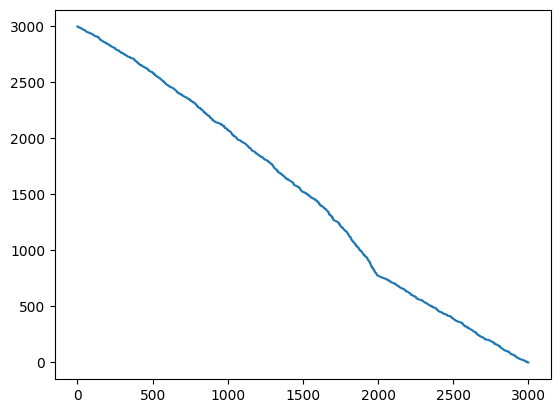

In [187]:
plt.plot([f(i,len(Z)-1) for i in range(len(Z))])

Notice that in this setting the data being studied becomes a parameter of the cost function. The core algorithms that are introduced shortly are only "aware" of the cost functions and not the underlying data.

## Core algorithms

### split

The first core algorithm, **split**, is quite primitive (and simple) but forms the basis for most of the other algorithms.

$split : (\cal{N} \times \cal{N} \rightarrow \cal{R},\cal{N} \times \cal{N} \rightarrow \cal{R},S \subset{\cal{}N}) \rightarrow \cal{N} \times \cal{R}$

In other words, $f$ and $g$ are cost functions and $S$ is a set of natural numbers.

More specifically, for $f,g \in \cal{N} \times \cal{N} \rightarrow \cal{R}$ and $S$, split returns a tuple $(k,c)$ where $k \in S$ is such that $f(\min(S),k) + g(k,\max(S)) = c$ is minimized.  

More concretely.

In [177]:
def split(f,g,R) :
    ra,rb = min(R),max(R)
    return min([(r,f(ra,r) + g(r,rb)) for r in R],key = lambda x : x[1])
    

If the computational complexities of $f$ and $g$ are $\cal{O}(f)$ and  $\cal{O}(g)$ respectively, then the complexity of split is $\cal{O}(|S|) \times \max(\cal{O}(f),\cal{O}(g))$

#### finding a changepoint with split

A single changepoint may be located using split by setting $g$ = $f$ and $S = {\rm dom}(f)$.

In [192]:
S = list(range(len(Z)))
split(f,f,S)

(1994, 2441.8996131796307)

Which can be confirmed visually.

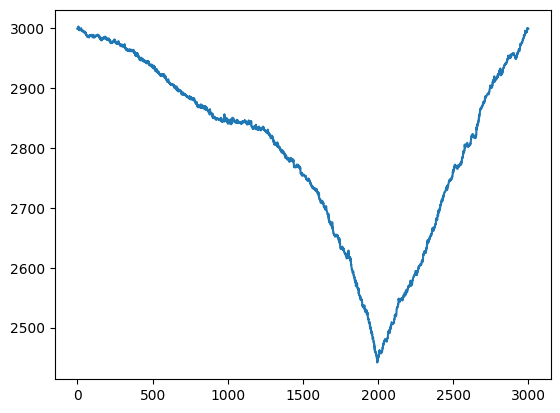

In [195]:
plt.plot([f(min(S),i) + f(i,max(S)) for i in S])

Note that the split algorithm is not "aware" of the underlying data - only the cost functions and a subset of the cost functions domain.

### amoc

The core algorithm **amoc** employs split to find a single changepoint subject to a threshold (penalty) being satisfied.

$amoc : (\cal{N} \times \cal{N} \rightarrow \cal{R},S \subset{\cal{}N},\cal{R}) \rightarrow \cal{N} \times \cal{R}$

More specifically, if $(k,c) = {\rm split}(g,g,S)$ then ${\rm amoc}(g,S,\beta) = (k,c+\beta)$ if $g(\min(S),\max(S)) - c > \beta$ or $(0,g(\min(S),\max(S))$ otherwise.

More concretely.

In [196]:
def amoc(g,R,beta) :
    def f(i,j) : return 0 if i == j else g(i,j-1) + beta
    return split(f,g,R)
    

Notice that, internally, amoc defines a new cost function $f$ in terms of the user defined cost function $g$.

It follows from the analysis of split that the  complexity of amoc is $\cal{O}(|S|) \cal{O}(f)$

####  using amoc

In [199]:
beta = 2*log(len(S)) # a good choice for beta
amoc(f,S,beta)

(1994, 2457.6307570304825)

In [201]:
beta = inf # prevent changepoint detection
amoc(f,S,beta)

(0, 2998.9999999999955)

### op

The core method **op** is (a somewhat generalised version of) the optimal partitioning algorithm **\[1\]**

$op : (\cal{N} \times \cal{N} \rightarrow \cal{R},S \subset{\cal{}N},\cal{R}_{\geq 0}) \rightarrow (\cal{N} \rightarrow (\cal{N} \times \cal{R}))$

More specifically

In [203]:
def op(g,R,beta) :
    class functor :
        def __init__(self) :
            self.D = {}
        def add(self,x,y) :
            self.D[x] = y
        def __call__(self,*arg) :
            _,x = arg
            return self.D[x]
    f = functor()
    ra = min(R)
    T = []
    segmentation = {}
    cost = -beta
    for r in R :
        f.add(r,cost + beta)
        T.append(r)
        index,cost = split(f,g,T)
        segmentation[r] = (index,cost)
    return segmentation

$g : \cal{N} \times \cal{N} \rightarrow \cal{R}$ \
$R$ an ordered subset of $\cal{N}$ \
$\beta \in \cal{R}_{\geq 0}$ \
\
$s \leftarrow f \leftarrow \{\}$ \
$c \leftarrow -\beta$ \
$T \leftarrow \left[\right]$ &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; _where_ $[]$ _is the empty ordered set_ \
for $r \in R$ \
&nbsp;&nbsp;&nbsp;&nbsp;$f \leftarrow f \cup \{(c + \beta)\}$ \
&nbsp;&nbsp;&nbsp;&nbsp;$T \leftarrow T \cup [r]$ \
&nbsp;&nbsp;&nbsp;&nbsp;$(k,c) \leftarrow {\rm split}(f,g,R)$ \
&nbsp;&nbsp;&nbsp;&nbsp;$s \leftarrow s \cup \{(k,c)\}$




In [202]:
def op(g,R,beta,prune) :
    class functor :
        def __init__(self) :
            self.D = {}
        def add(self,x,y) :
            self.D[x] = y
        def __call__(self,*arg) :
            _,x = arg
            return self.D[x]
    f = functor()
    ra = min(R)
    T = []
    segmentation = {}
    cost = -beta
    for r in R :
        f.add(r,cost + beta)
        T.append(r)
        if prune :
            T = [t for t in T if f(ra,t) + g(t,r) <= f(ra,r) + beta]
        index,cost = split(f,g,T)
        segmentation[r] = (index,cost)
    return segmentationcupcup
    

In [5]:
def pelt(g,R,beta) :
    return op(g,R,beta,True)

In [114]:
def changepoints(segmentations,rb = None) :
    ra = min(segmentations)
    if rb == None :
        rb = max(segmentations)
    index = rb
    locations = []
    while index != ra :
        index,_ = segmentations[index]
        locations.append(index)
    return locations

In [7]:
class sumstats :
    def __init__(self,X) :
        self.X = X
        self.SX = [0] + list(accumulate(X))
        self.SXX = [0] + list(accumulate([x*x for x in X]))

In [8]:
class normal_mean :
    def __init__(self,X) :
        self.sumstats = sumstats(X)
    def __call__(self,i,j) :
        val = self.sumstats.SX[j+1] - self.sumstats.SX[i]
        val *= val
        val /= (j - i + 1)
        val = -val
        val += self.sumstats.SXX[j+1] - self.sumstats.SXX[i]
        return val

In [9]:
X = [0.0 for i in range(1000)] + [1.0 for i in range(1000)] 
E = norm.rvs(size=len(X))
Z = [x+e for x,e in zip(X,E)]
#mu = mean(Z)
#sigma = sqrt(variance(Z))
#Z = [(z-mu)/sigma for z in Z]
#plt.plot(Z)
#plt.show()

In [17]:
g = normal_mean(Z)
amoc(g,list(range(len(Z))),2*log(len(Z)))

(1001, 2066.495941060478)

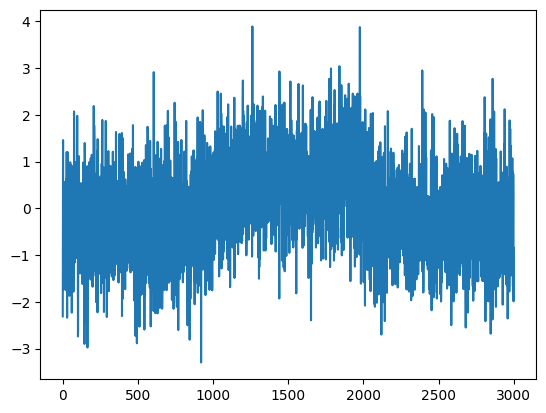

In [11]:
X = [0.0 for i in range(1000)] + [1.0 for i in range(1000)] + [0.0 for i in range(1000)]
E = norm.rvs(size=len(X))
Z = [x+e for x,e in zip(X,E)]
mu = mean(Z)
sigma = sqrt(variance(Z))
Z = [(z-mu)/sigma for z in Z]
plt.plot(Z)
plt.show()

In [12]:
g = normal_mean(Z)
start =  time.perf_counter()
res = op(g,list(range(len(Z))),2*log(len(Z)))
end =  time.perf_counter()
print(changepoints(res))
print(end-start)

[2001, 996, 0]
3.415971000213176


In [13]:
g = normal_mean(Z)
start =  time.perf_counter()
res = pelt(g,list(range(len(Z))),2*log(len(Z)))
end =  time.perf_counter()
print(changepoints(res))
print(end-start)

[2001, 996, 0]
2.721504464978352


In [52]:
file = open("X.csv", "r")
X = list(csv.reader(file, delimiter=","))
X = [float(item) for sublist in X for item in sublist]
file.close()
print(mean(X),sqrt(variance(X)))

-3.9863529867114243e-17 1.0


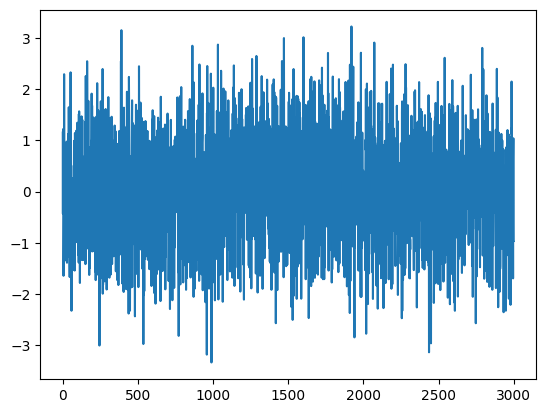

In [53]:
plt.plot(X)
plt.show()

In [57]:
g = normal_mean(X)
g(1,3)
g(0,0)
g(len(X)-1,len(X)-1)
split(g,g,list(range(len(X))))

(1024, 2973.3114425626513)

In [16]:
g = normal_mean(X)
start =  time.perf_counter()
res = op(g,list(range(len(X))),2*log(len(X)))
end =  time.perf_counter()
print(changepoints(res))
print(end - start)

[1933, 1025, 0]
2.8561626009177417


In [17]:
g = normal_mean(X)
start =  time.perf_counter()
res = pelt(g,list(range(len(X))),2*log(len(X)))
end =  time.perf_counter()
print(changepoints(res))
print(end - start)

[1933, 1025, 0]
4.567221871111542


In [18]:
import numpy as np

import matplotlib.pyplot as plt

from scipy import stats

rng = np.random.default_rng()

In [19]:
X1 = list(range(200))
E1 = norm.rvs(size=len(X1))
a1 = 1.6
b1 = 2
Y1 = [a1*x + b1 + e for x,e in zip(X1,E1)]
X2 = [x + len(X1) for x in X1]
E2 = norm.rvs(size=len(X2))
a2 = 1.0
b2 = (a1-a2)*X1[-1] + b1 
Y2 = [a2*x + b2 + e for x,e in zip(X2,E2)]
X = X1 + X2
Y = Y1 + Y2


In [20]:
res = stats.linregress(X, Y)
Y_hat = [res.slope*x + res.intercept for x in X]

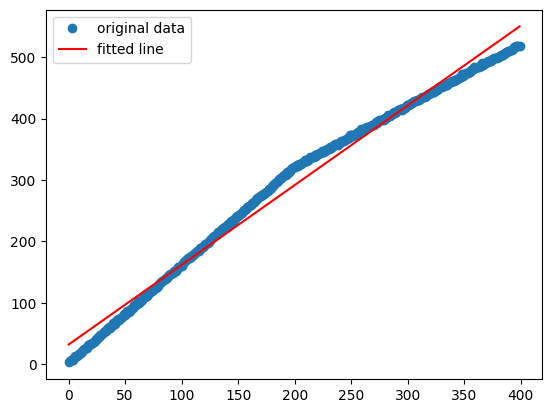

In [21]:
plt.plot(X, Y, 'o', label='original data')

plt.plot(X, Y_hat, 'r', label='fitted line')

plt.legend()

plt.show()

In [22]:
res

LinregressResult(slope=1.2989379955833804, intercept=31.846230245158438, rvalue=0.9933403397426972, pvalue=0.0, stderr=0.0075520625262702964, intercept_stderr=1.7408036527128457)

In [23]:
class linear :
    def __init__(self,X,Y) :
        self.X = X
        self.Y = Y
    def __call__(self,i,j) :
        if i ==j :
            return inf
        regression = stats.linregress(self.X[i:(j+1)],self.Y[i:(j+1)])
        a = regression.slope
        b = regression.intercept
        return sum([(y - a*x - b)*(y - a*x - b) for x,y in zip(self.X[i:(j+1)],self.Y[i:(j+1)])])

In [24]:
g = linear(X,Y)
start =  time.perf_counter()
res = op(g,list(range(len(X))),2*log(len(X)))
end =  time.perf_counter()
print(changepoints(res))
print(end - start)

[378, 356, 203, 202, 0]
8.220623875036836


In [191]:
class eCDFfh :
    def __init__(self,X,k) :
        def quantiles(T,k) :
            # this function computes k quantiles in data from a window of size n
            # the expression for the probabilities is taken from Zou (2014) and 
            # Haynes (2017) and is designed to add emphasis to the tails of the 
            # probability distribution. Both authors show doing so increases power.
            # data is the data to use for computing the quantiles
            # k is the number of quantiles and n is the window size
            n = len(T)
            def quantile(prob) :
                #this function works out the quantile value
                #it uses linear interpolation, ie quantile type = 7
                h = (n - 1) * prob
                h_floor = int(h)
                if h_floor == h:
                    return T[h]
                else:
                    non_int_part = h - h_floor 
                    lower = T[h_floor]
                    upper = T[h_floor + 1]
                    return lower + non_int_part * (upper - lower)
            c = log(2*n-1)   # weight as in Zou (2014)
            probs = [(1/(1+(2*(n-1)*exp((-c/k)*(2*i-1))))) for i in range(k)]
            return [quantile(p) for p in probs]    
        
        def eCDF(T,Q):    
            # used to return value of eCDF, not cost, at a given quantile  
            # data is the tree of data used to compute the ecdf
            # quantile is the numeric quantile value
            vals = []
            for q in Q :
                left = T.bisect_left(q)
                right = T.bisect_right(q)
                # value is number of points to left of quantile, plus 0.5 times
                # the points equal to the quantile
                vals.append((left+0.5*(right-left))/len(T))
            return vals
        
        def cost(cdf_vals,w):
            #function for computing the likelihood function
            #cdf_val is the value of the eCDF at a set quantile
            #seg_len is the length of the data used
            val = 0.0
            for cdf_val in cdf_vals : 
                if(cdf_val > 0 and cdf_val < 1):
                    conj = 1 - cdf_val
                    val += w * (cdf_val * log(cdf_val) - conj * log(conj))
            return(val)
        
        
        self.n = len(X)
        self.X = X
        self.T = OST(X)
        self.k = k
        # determine quantiles
        self.Q = quantiles(self.T,self.k)
        # determine eCDF
        self.L = {}
        for j in range(self.n) :
            self.T = OST(self.X[:(j+1)])
            for i in range(j+1) :
                self.L[(i,j)] = cost(eCDF(self.T,self.Q),self.n)
                self.T.remove(self.X[i])
                
    def __call__(self,i,j) :
        return self.L[(i,j)]
        
        
        

In [196]:
g = eCDFfh(Z,8)

In [189]:
R = list(range(len(Z)))
res = op(g,R,64*log(len(Z)))

In [190]:
res[1999]

(1995, -184.9680997275845)

In [180]:
changepoints(res)

KeyboardInterrupt: 

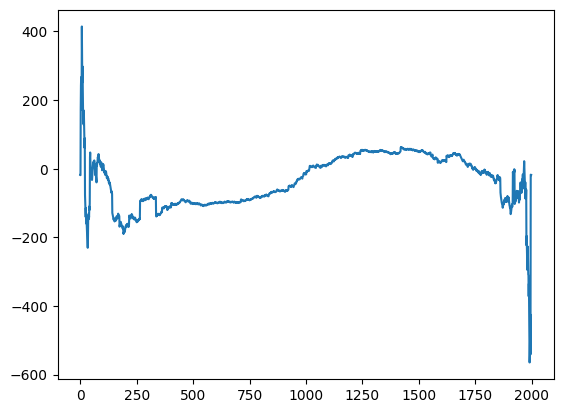

In [197]:

cost = [g(0,i) + g(i+1,1999) for i in range(len(Z)-1)]
plt.plot(cost)
    

In [160]:
2*log(len(X))

15.201804919084164

In [166]:
print(g(0,1999),min(cost))


18.4176633926834 -2.385781198510511


In [11]:
class npConditional :
    def __init__(self,X,Q) :
        # Note - this initialisation is O(len(X))
        self.n = len(X)
        k = len(Q)
        # Calculate summary statistics
        self.S = {-1 : tuple((k-1)*[0])}
        for i in range(self.n) :
            self.S[i] = tuple([int(X[i] > a and X[i] <= b) for a,b in zip(Q[:-1],Q[1:])])
        for i in range(self.n) :
            self.S[i] = tuple([self.S[i][j] + self.S[i-1][j] for j in range(k-1)])
        
    def getS(self) :
        return self.S
    def __call__(self,i,j) :
        # Note - this evaluation is O(len(Q))
        t = j - i + 1
        M = [a-b for a,b in zip(self.S[j],self.S[i])]
        return sum([-m*log(m/t) for m in M if m != 0 and m != t])
        
        
                    
            
        

In [41]:
def quantiles(X,K) :
    n = len(X)
    X_sorted = sorted(X)
    c = -log(2*n-1)
    pK = [(1+exp(c*(-1+2*(k+1)/K-1/K)))**-1 for k in range(K)]
    I = [int((n-1)*p) for p in pK]
    return [-inf] + [X_sorted[i] for i in I] + [inf]

def penalty(X,Q,threshold) :
    k = len(Q) - 2
    n = len(X)
    return k + 2*sqrt(k*threshold*log(n)) + 2*threshold*log(n)
    
    
    

In [26]:
K = 24
Q = quantiles(Z,K)
beta = penalty(Z,Q,0.01)
n = len(Z)
R = list(range(n))
g = npConditional(Z,Q)

1001

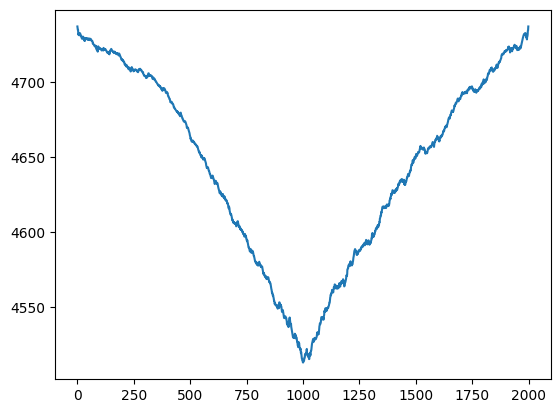

In [31]:
C = [g(0,i) + g(i,n-1) for i in range(n)]
plt.plot(C)
C.index(min(C))

In [32]:
res = pelt(g,R,beta)

In [33]:
changepoints(res)

[1002, 0]

In [47]:
file = open("Y.csv", "r")
Y = list(csv.reader(file, delimiter=","))
Y = [float(item) for sublist in Y for item in sublist]
file.close()
print(mean(Y),sqrt(variance(Y)))

0.5118908759583684 1.0939846232337178


In [48]:
K = 24
Q = quantiles(Y,K)
beta = penalty(Y,Q,0.01)
n = len(Y)
R = list(range(n))
g = npConditional(Y,Q)

In [49]:
beta

26.518121592815238

In [50]:
res = pelt(g,R,beta)

In [51]:
changepoints(res)

[202, 0]

In [ ]:
Hi James

Hope you are keeping well.

Please find attached your feedback and marks for the STOR-601 Interfacing R and C++ assessment. If you have any questions regarding the feedback then do please get in touch.


Looking forward to working with you during your PhD programme.

Best wishes,

Dan

In [139]:
class sop :
    class functor :
        def __init__(self) :
            self.D = {}
        def add(self,x,y) :
            self.D[x] = y
        def __call__(self,*arg) :
            _,x = arg
            return self.D[x]
    def __init__(self) :
        self.f = sop.functor()
        self.T = []
        self.ra = None
        self.segmentation = {}
        self.cost = 0
        self.beta = 0
    def update(self,g,R,beta,prune = False) :
        if self.ra == None :
            self.ra = min(R)
        for r in R : 
            self.f.add(r,self.cost + self.beta)
            self.beta = beta
            self.T.append(r)
            if prune :
                self.T = [t for t in self.T if self.f(self.ra,t) + g(t,r) <= self.f(self.ra,r) + beta]
            index,self.cost = split(self.f,g,self.T)
            self.segmentation[r] = (index,self.cost)
        
        
            
        
            
    

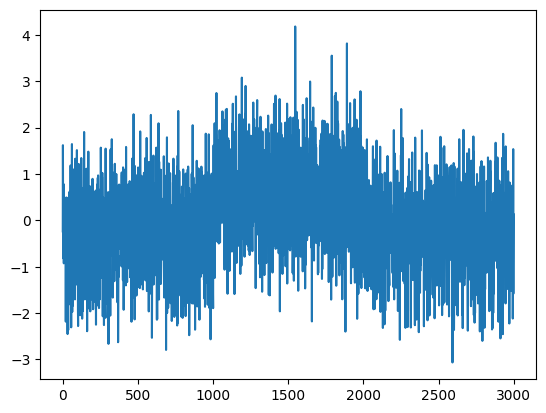

In [62]:
X = [0.0 for i in range(1000)] + [1.0 for i in range(1000)] + [0.0 for i in range(1000)]
E = norm.rvs(size=len(X))
Z = [x+e for x,e in zip(X,E)]
mu = mean(Z)
sigma = sqrt(variance(Z))
Z = [(z-mu)/sigma for z in Z]
plt.plot(Z)
plt.show()

In [148]:
opt = sop()

In [65]:
g = normal_mean(Z)
beta = 2*log(len(Z))

In [149]:
opt.update(g,[0],beta,True)

In [102]:
opt.T

[0]

In [103]:
opt.segmentation

{0: (0, 0.0)}

In [150]:
opt.update(g,list(range(1,1050)),beta,True)

In [143]:
changepoints(opt.segmentation)

[1010, 0]

In [151]:
opt.update(g,list(range(1050,2100)),beta,True)

In [152]:
changepoints(opt.segmentation)

[2006, 1010, 0]

In [153]:
opt.T

[1832,
 1833,
 1834,
 1873,
 1876,
 1877,
 1878,
 1879,
 1880,
 1882,
 1883,
 1884,
 1885,
 1886,
 1887,
 1888,
 1890,
 1891,
 1892,
 1893,
 1894,
 1895,
 1896,
 1897,
 1898,
 1899,
 1900,
 1901,
 1902,
 1903,
 1904,
 1905,
 1906,
 1907,
 1908,
 1909,
 1910,
 1911,
 1912,
 1913,
 1914,
 1915,
 1916,
 1917,
 1918,
 1919,
 1920,
 1921,
 1922,
 1923,
 1924,
 1925,
 1926,
 1927,
 1928,
 1929,
 1930,
 1931,
 1932,
 1933,
 1934,
 1935,
 1936,
 1937,
 1938,
 1939,
 1940,
 1941,
 1942,
 1943,
 1944,
 1945,
 1946,
 1947,
 1948,
 1949,
 1950,
 1951,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 1958,
 1959,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,

In [154]:
opt.update(g,list(range(2100,3000)),beta,True)

In [155]:
changepoints(opt.segmentation)

[2006, 1010, 0]

In [95]:
res = op(g,list(range(3000)),beta)

In [133]:
changepoints(res,2040)

[2006, 1010, 0]

$f \leftarrow f \cup \{(x,y)\}$

## References

[1] _An Algorithm for Optimal Partitioning of
Data on an Interval_ \
Brad Jackson, Jeffrey D. Scargle, David Barnes, Sundararajan Arabhi, Alina Alt, Peter Gioumousis, Elyus Gwin,
Paungkaew Sangtrakulcharoen, Linda Tan, and Tun Tao Tsai 2003  \
**arXiv:math/0309285** 
